## Import Statements

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import time as timer
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

## Useful Functions

In [ ]:
def ReadPickle(filename: str) -> dict:
  '''Reads in data from given pickle files, outputs a dictionary'''
  try:
    Data = pd.read_pickle(filename)
  except FileNotFoundError:
    raise FileNotFoundError(f'Error reading {filename}')
  return Data

## Hyperparams

In [ ]:
lr = 0.00015
num_epochs = 120
delta = 0.75
test_size = 0.1
val_size = 0.2
random_state = 42
batch_size = 128
Input_File = 'SolvedDatasetv2.pickle'
model_name = 'NNv2'

tmin = 2.9
tmax = 4.0

rmin = 1e-6
rmax = 1.1

history = {'train_loss':[],'val_loss':[],'lr':[]}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [ ]:
print(f"Loading Dataset -- '{Input_File}'")
t_Load1 = timer.time()
data = ReadPickle(Input_File)
t_Load2 = timer.time()
samples = len(data)
nt, nr = data[0]['N'].shape
print(f"Dataset took {round(t_Load2-t_Load1,2)}s to load")
print(f"Dataset Contains {samples} samples.")
print(f"Grid Dimensions:  nt - {nt}, nr - {nr}")

############### CHECK VALUES ###############
if batch_size%2 != 0:
    raise ValueError(f"batch_size must be a  multiple of 2:  {batch_size}")
if nt%2 != 0:
    raise ValueError(f"nt must be a  multiple of 2:  {nt}")
if nr%2 != 0:
    raise ValueError(f"nr must be a  multiple of 2:  {nr}")

Loading Dataset -- 'SolvedDatasetv2.pickle'
Dataset took 67.7s to load
Dataset Contains 100000 samples.
Grid Dimensions:  nt - 1000, nr - 50


## Classes and Functions

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input2d_array, input1d_array, input_t_array, input_r_array, target1, target2):
        '''Docstring WIP'''
        self.input2d_array = torch.tensor(input2d_array, dtype=torch.float32)
        self.input1d_array = torch.tensor(input1d_array, dtype=torch.float32)
        self.input_t_array = torch.tensor(input_t_array, dtype=torch.float32)
        self.input_r_array = torch.tensor(input_r_array, dtype=torch.float32)
        self.target1 = torch.tensor(target1, dtype=torch.float32)
        self.target2 = torch.tensor(target2, dtype=torch.float32)

    def __len__(self):
        '''Docstring WIP'''
        return len(self.input2d_array)

    def __getitem__(self, idx):
        '''Docstring WIP'''
        input2d = self.input2d_array[idx]
        input1d = self.input1d_array[idx]
        input_t = self.input_t_array[idx]
        input_r = self.input_r_array[idx]
        target1 = self.target1[idx]
        target2 = self.target2[idx]
        return input2d, input1d, input_t, input_r, target1, target2
class CustomCNN(nn.Module):
    def __init__(self):
        '''Docstring WIP'''
        super(CustomCNN, self).__init__()

        #Convolutional Layers
        self.conv2d_1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=(2, 2))
        self.conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=(2, 2))
        self.conv2d_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=(2, 2))

        #Pooling Layers
        self.pool2d_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.pool2d_2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.pool2d_3 = nn.MaxPool2d(kernel_size=(2, 1))
        self.pool2d_4 = nn.MaxPool2d(kernel_size=(2, 1))

        #Fully Connected Layers
        self.fc_combined = nn.Linear(128 * (nt // 16) * (nr // 4), 4096)
        self.fc_out1 = nn.Linear(4096, 2048)
        self.fc_out2 = nn.Linear(2048, 1024)
        self.fc_out3 = nn.Linear(1024, 512)
        self.fc_out4 = nn.Linear(512, 256)
        self.fc_out5 = nn.Linear(256, 128)
        self.fc_out6 = nn.Linear(128, 128)
        self.fc_out7 = nn.Linear(128, 128)

        #Split Output Layers
        self.pathway1a = nn.Linear(128,64)
        self.pathway1b = nn.Linear(64,64)
        self.pathway2a = nn.Linear(128,64)
        self.pathway2b = nn.Linear(64,64)
        self.output1 = nn.Linear(64, nr)
        self.output2 = nn.Linear(64, nr)

    def forward(self, input2d, input1d, input_t, input_r):
        '''Docstring WIP'''
        #Expanding Data to Uniform Grid Tensor
        x2d = input2d
        x1d = input1d
        xt = input_t.unsqueeze(2).repeat(1, 1, nr)
        xr = input_r.unsqueeze(1).repeat(1, nt, 1)
        input_combined = torch.stack([x2d, x1d, xt, xr], dim=1)

        #Apply Convolution and Pooling
        x1a = F.selu(self.conv2d_1(input_combined))
        x1b = self.pool2d_1(x1a)
        x2a = F.selu(self.conv2d_2(x1b))
        x2b = self.pool2d_2(x2a)
        x3a = F.selu(self.conv2d_3(x2b))
        x3b = self.pool2d_3(x3a)
        x4a = F.selu(self.conv2d_4(x3b))
        x4b = self.pool2d_4(x4a)

        x = x4b.view(x4b.size(0), -1)

        #Apply Fully Connected Layers
        x_combined1 = F.selu(self.fc_combined(x))
        x_combined2 = F.selu(self.fc_out1(x_combined1))
        x_combined3 = F.selu(self.fc_out2(x_combined2))
        x_combined4 = F.selu(self.fc_out3(x_combined3))
        x_combined5 = F.leaky_relu(self.fc_out4(x_combined4))
        x_combined6 = F.leaky_relu(self.fc_out5(x_combined5))
        x_combined7 = F.leaky_relu(self.fc_out6(x_combined6))
        x_combined8 = F.leaky_relu(self.fc_out7(x_combined7))

        #Partition Data Streams For Output1 and Output2
        out1a_hidden = F.leaky_relu(self.pathway1a(x_combined8))
        out2a_hidden = F.leaky_relu(self.pathway2a(x_combined8))
        out1b_hidden = F.leaky_relu(self.pathway1b(out1a_hidden))
        out2b_hidden = F.leaky_relu(self.pathway2b(out2a_hidden))

        #Output Layers
        out1 = self.output1(out1b_hidden)
        out2 = self.output2(out2b_hidden)

        return out1, out2
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs=20):
    '''Docstring WIP'''
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    model.apply(init_weights)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for i, (input2d, input1d, input_t, input_r, target1, target2) in enumerate(train_loader):
            input2d, input1d = input2d.to(device), input1d.to(device)
            input_t = input_t.to(device)
            input_r = input_r.to(device)
            target1, target2 = target1.to(device), target2.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                output1, output2 = model(input2d, input1d, input_t, input_r)
                loss1 = criterion(output1, target1)
                loss2 = criterion(output2, target2)
                loss = loss1 + loss2

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        scheduler.step()

        history['train_loss'].append(running_loss/len(train_loader))
        history['lr'].append(scheduler.get_last_lr()[0])
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.4f}')


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for input2d, input1d, input_t, input_r, target1, target2 in val_loader:
                input2d, input1d = input2d.to(device), input1d.to(device)
                input_t = input_t.to(device)
                input_r = input_r.to(device)
                target1, target2 = target1.to(device), target2.to(device)

                output1, output2 = model(input2d, input1d, input_t, input_r)

                loss1 = criterion(output1, target1)
                loss2 = criterion(output2, target2)
                loss = loss1 + loss2
                val_loss += loss.item()


        history['val_loss'].append(val_loss/len(val_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(val_loader):.4f}')
def test_model(model, test_loader, criterion):
    '''Docstring WIP'''
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for input2d, input1d, input_t, input_r, target1, target2 in test_loader:
            input2d, input1d = input2d.to(device), input1d.to(device)
            input_t = input_t.to(device)
            input_r = input_r.to(device)
            target1, target2 = target1.to(device), target2.to(device)

            output1, output2 = model(input2d, input1d, input_t, input_r)

            loss1 = criterion(output1, target1)
            loss2 = criterion(output2, target2)
            loss = loss1 + loss2
            test_loss += loss.item()

    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
def split_data(input2d_array, input1d_array, input_t_array, input_r_array, target1, target2, test_size=0.2, val_size=0.1):
    '''Docstring WIP'''
    #Split Off Test Data
    input2d_trainval, input2d_test, input1d_trainval, input1d_test, input_t_trainval, input_t_test, input_r_trainval, input_r_test, target1_trainval, target1_test, target2_trainval, target2_test = \
        train_test_split(input2d_array, input1d_array, input_t_array, input_r_array, target1, target2, test_size=test_size, random_state=random_state)

    #Split Off Val Data
    val_ratio = val_size / (1 - test_size)
    input2d_train, input2d_val, input1d_train, input1d_val, input_t_train, input_t_val, input_r_train, input_r_val, target1_train, target1_val, target2_train, target2_val = \
        train_test_split(input2d_trainval, input1d_trainval, input_t_trainval, input_r_trainval, target1_trainval, target2_trainval, test_size=val_ratio, random_state=random_state)

    #Output Split Data
    return (input2d_train, input1d_train, input_t_train, input_r_train, target1_train, target2_train), \
           (input2d_val, input1d_val, input_t_val, input_r_val, target1_val, target2_val), \
           (input2d_test, input1d_test, input_t_test, input_r_test, target1_test, target2_test)

## Setting Up Network

In [ ]:
#Startup
print('Initializing Network')
t_init = timer.time()

#Define Rho and Time Arrays
t = np.linspace(tmin, tmax, nt)
r = np.linspace(rmin, rmax, nr)

#Initialize Scalers
scalerN = StandardScaler()
scalerS = StandardScaler()
scalerD = StandardScaler()
scalerV = StandardScaler()

#Import Raw Data and Scale
input2d_array = np.array([i["N"] for i in data]).astype(np.float32) #N
inputST_array = np.array([i["ST"] for i in data]).astype(np.float32) #ST
inputSR_array = np.array([i["SR"] for i in data]).astype(np.float32) #SR
input1d_array = np.array([np.outer(STi, SRi) for STi, SRi in zip(inputST_array, inputSR_array)]) #S
input_t_array = np.array([t for _ in range(samples)]).astype(np.float32) #t
input_r_array = np.array([r for _ in range(samples)]).astype(np.float32) #r
target1 = scalerD.fit_transform(np.array([i["D"] for i in data]).astype(np.float32)) #D
target2 = scalerV.fit_transform(np.array([i["V"] for i in data]).astype(np.float32)) #V

#Process S Data
input1d_array_reshaped = input1d_array.reshape(-1, input1d_array.shape[1])
input1d_array_reshaped_scaled = scalerS.fit_transform(input1d_array_reshaped)
input1d_array = input1d_array_reshaped_scaled.reshape(input1d_array.shape)

#Process N Data
input2d_array_reshaped = input2d_array.reshape(-1, input2d_array.shape[1])
input2d_array_reshaped_scaled = scalerN.fit_transform(input2d_array_reshaped)
input2d_array = input2d_array_reshaped_scaled.reshape(input2d_array.shape)

(train_data, val_data, test_data) = split_data(input2d_array, input1d_array, input_t_array, input_r_array, target1, target2)

#Initialize DataSets
train_dataset = CustomDataset(*train_data)
val_dataset = CustomDataset(*val_data)
test_dataset = CustomDataset(*test_data)

#Initialize Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = CustomCNN().to(device)
criterion = nn.HuberLoss(reduction="mean", delta=delta)
optimizer = optim.AdamW(model.parameters(), lr=lr)
num_steps = len(train_loader)*num_epochs
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_steps, last_epoch=-1, eta_min=0)
scaler = torch.amp.GradScaler("cuda")

t_start = timer.time()
print(f'Initialization Took {round(t_start - t_init,2)}s')
print(f'Beggining Training')

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs=num_epochs)
test_model(model, test_loader, criterion)

Initializing Network
Initialization Took 254.98s
Beggining Training
Epoch [1/120], Training Loss: 0.4151
Epoch [1/120], Validation Loss: 0.2283
Epoch [2/120], Training Loss: 0.2276
Epoch [2/120], Validation Loss: 0.1994
Epoch [3/120], Training Loss: 0.1735
Epoch [3/120], Validation Loss: 0.1567
Epoch [4/120], Training Loss: 0.1349
Epoch [4/120], Validation Loss: 0.1633
Epoch [5/120], Training Loss: 0.1157
Epoch [5/120], Validation Loss: 0.0899
Epoch [6/120], Training Loss: 0.0823
Epoch [6/120], Validation Loss: 0.0807
Epoch [7/120], Training Loss: 0.0720
Epoch [7/120], Validation Loss: 0.0696
Epoch [8/120], Training Loss: 0.0737
Epoch [8/120], Validation Loss: 0.0755
Epoch [9/120], Training Loss: 0.0696
Epoch [9/120], Validation Loss: 0.0693
Epoch [10/120], Training Loss: 0.0599
Epoch [10/120], Validation Loss: 0.0702
Epoch [11/120], Training Loss: 0.0502
Epoch [11/120], Validation Loss: 0.0448
Epoch [12/120], Training Loss: 0.0402
Epoch [12/120], Validation Loss: 0.0399
Epoch [13/120]

### TODO
* Train of validation
* add checkpoints, modelsaving, progress bar

## Predictions

In [ ]:
O1 = 1; O2 = 2; T1 = 1; T2 = 2
model.eval()
with torch.no_grad():
    for input2d, input1d, input_t, input_r, target1, target2 in test_loader:
            input2d, input1d = input2d.to(device), input1d.to(device)
            input_t = input_t.to(device)
            input_r = input_r.to(device)
            target1, target2 = target1.to(device), target2.to(device)

            output1, output2 = model(input2d, input1d, input_t, input_r)
            O1 = output1.cpu().numpy()
            O2 = output2.cpu().numpy()
            T1 = target1.cpu().numpy()
            T2 = target2.cpu().numpy()

Output1_check = scalerD.inverse_transform(O1)
Output2_check = scalerV.inverse_transform(O2)
Target1_check = scalerD.inverse_transform(T1)
Target2_check = scalerV.inverse_transform(T2)

In [ ]:
# input2d_array = data[0]['N']
# input2d_array
# import pickle
# with open("ExampleDensity.pickle", 'wb+') as f:
#         # Pickle the 'data' dictionary using the highest protocol available.
#         pickle.dump(input2d_array, f, pickle.HIGHEST_PROTOCOL)

## Results

In [ ]:
i=0
#11,13,18
#5,11,14,18,22

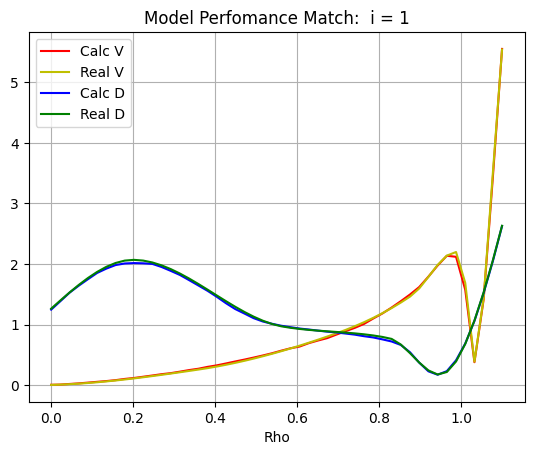

In [ ]:
imax = Output1_check.shape[0]
index = i#np.random.randint(0,imax) #6
if i < batch_size-1:
    i += 1
else:
    i = 0
def PlotRes(index):
    Fig = plt.figure()
    Output1_check_idx = Output1_check[index]
    Output2_check_idx = Output2_check[index]
    Target1_check_idx = Target1_check[index]
    Target2_check_idx = Target2_check[index]

    plt.plot(r,Output2_check_idx,'-r', label='Calc V')
    plt.plot(r,Target2_check_idx,'-y',label='Real V')
    plt.plot(r,Output1_check_idx,'-b', label='Calc D')
    plt.plot(r,Target1_check_idx,'-g',label='Real D')

    plt.xlabel('Rho')
    plt.title(f'Model Perfomance Match:  i = {index}')
    plt.legend()
    plt.grid()
    plt.show()
PlotRes(i)

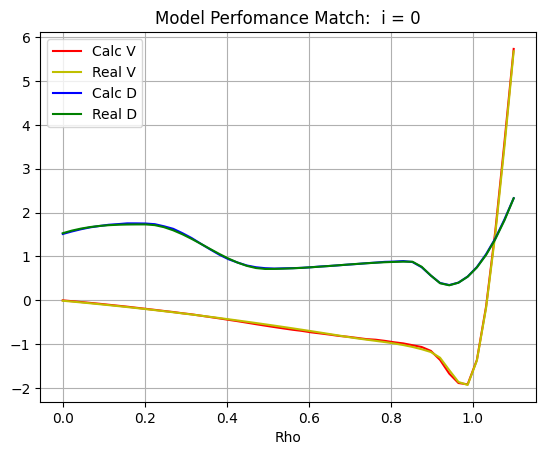

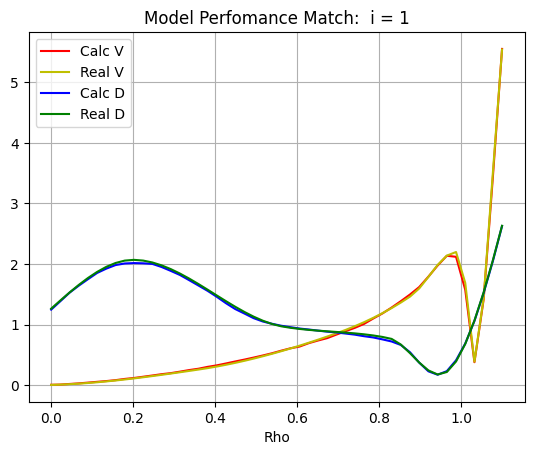

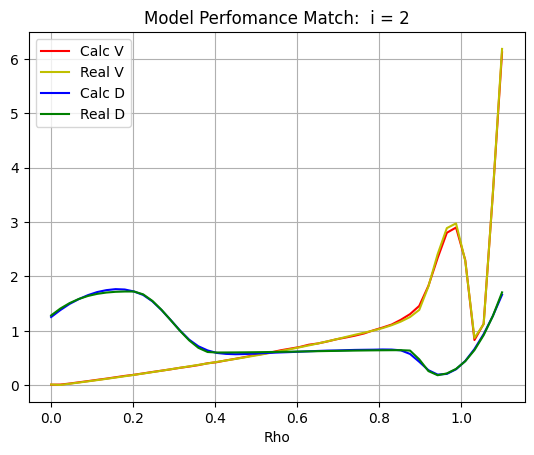

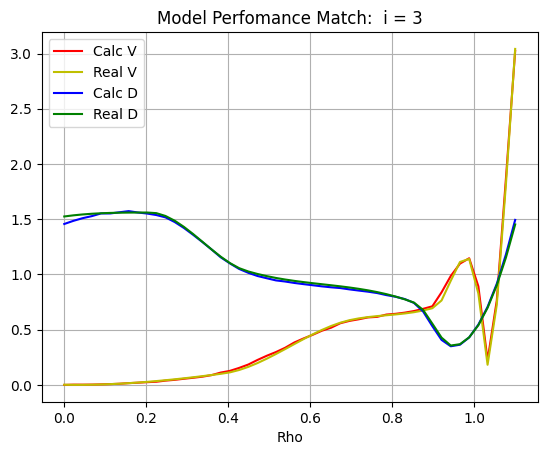

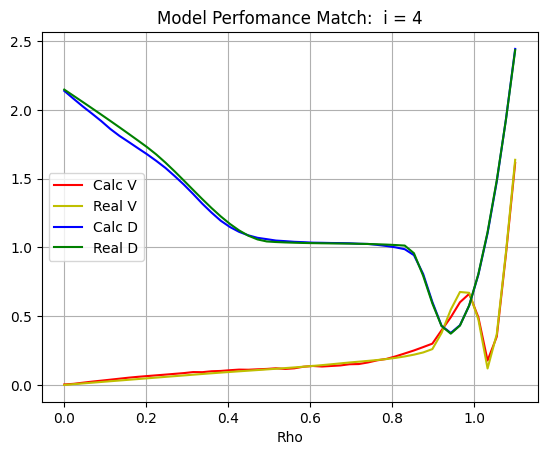

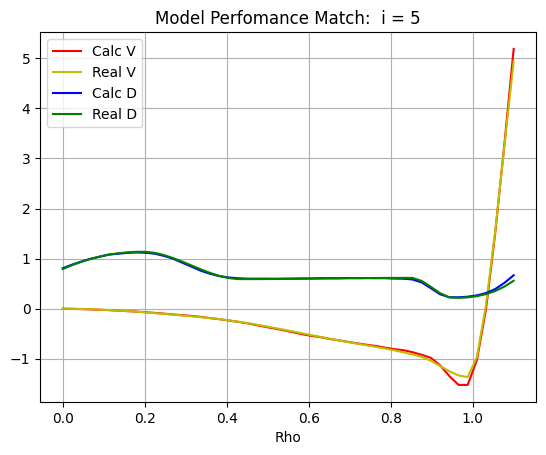

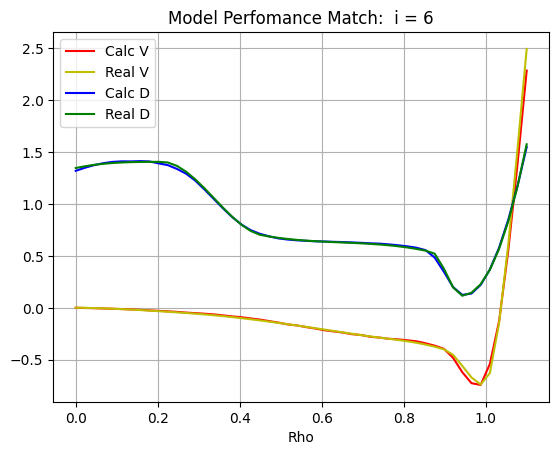

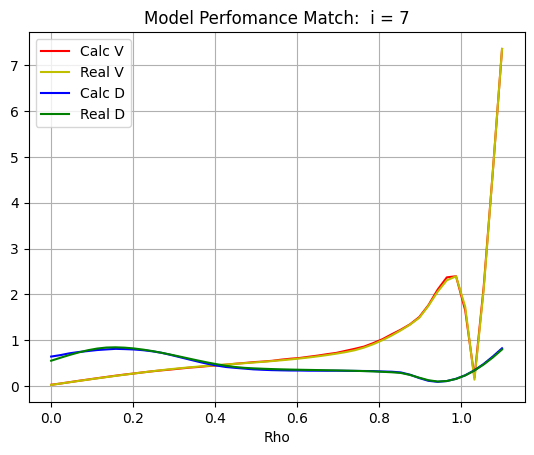

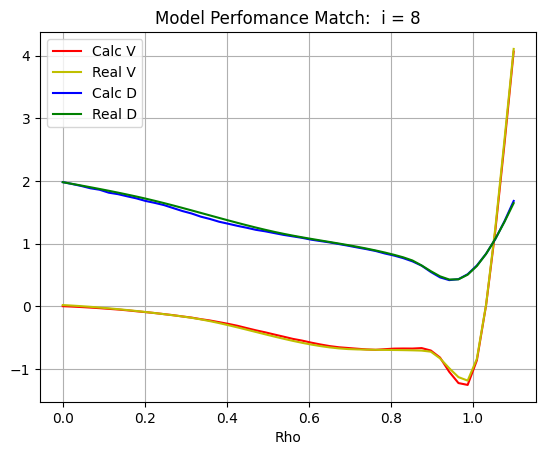

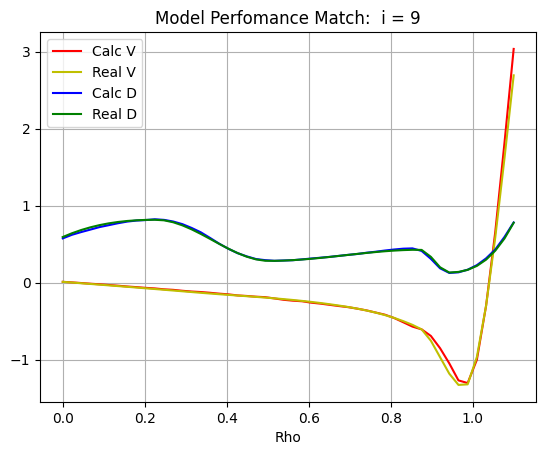

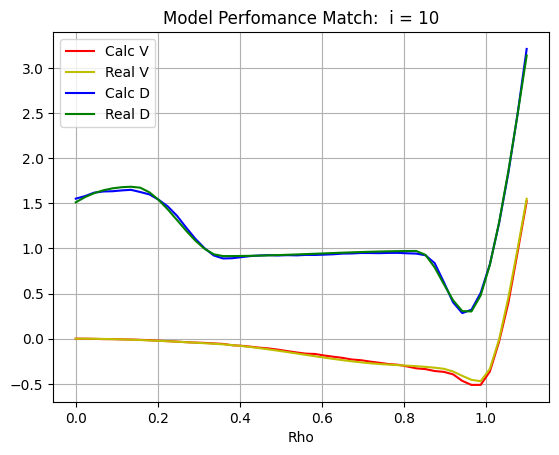

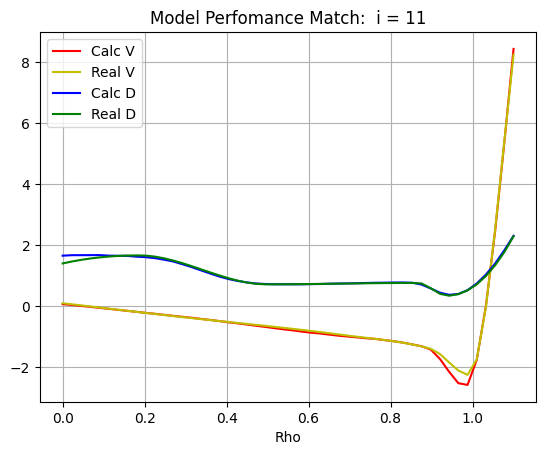

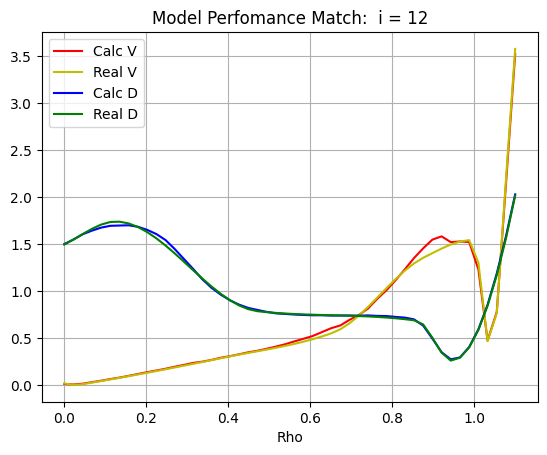

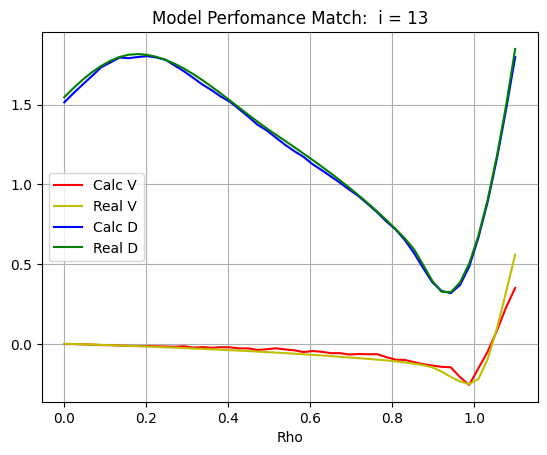

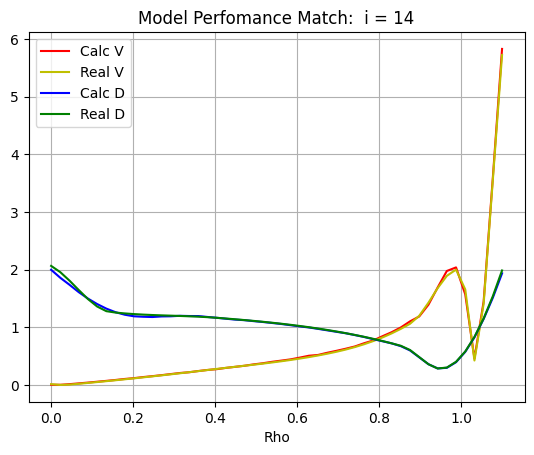

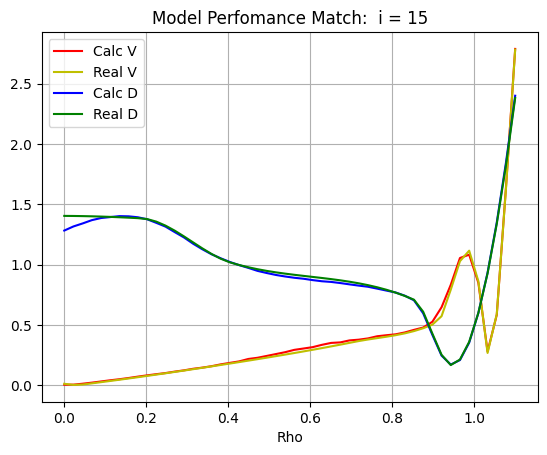

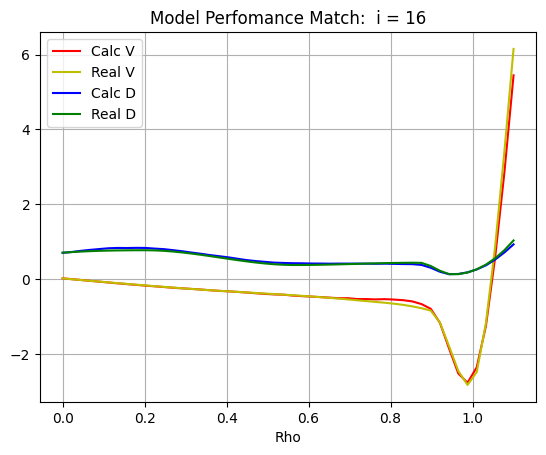

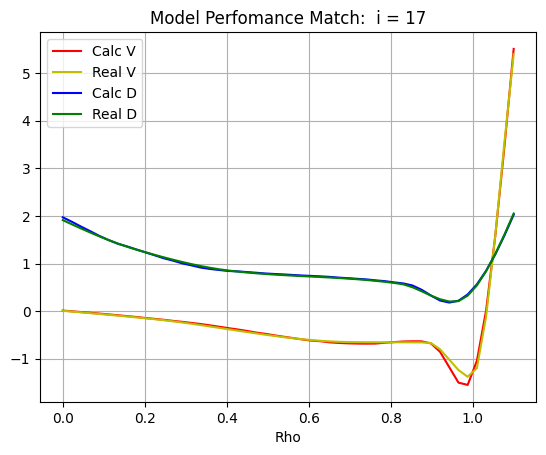

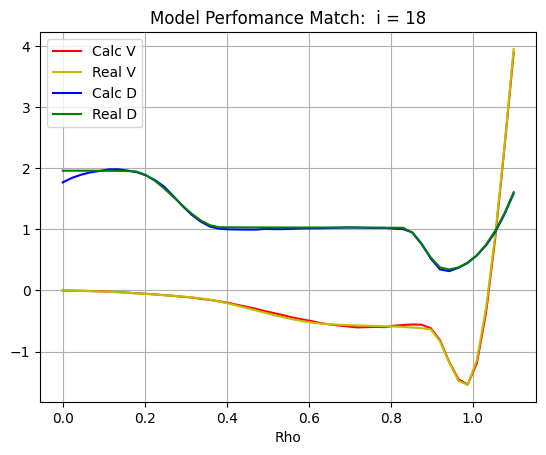

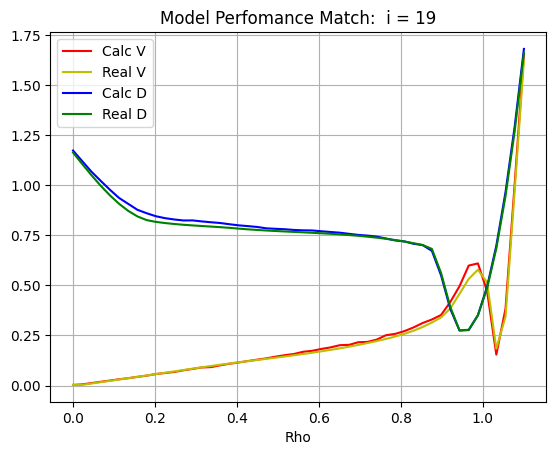

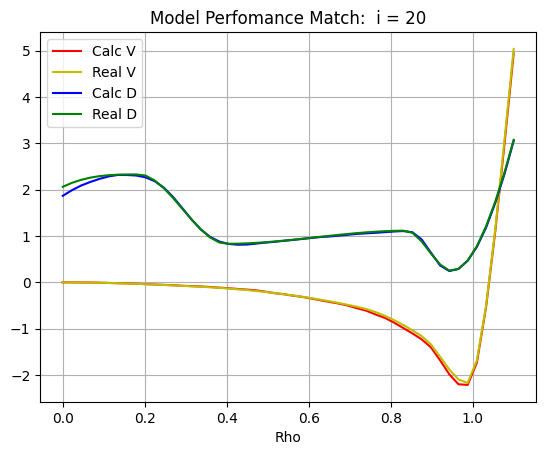

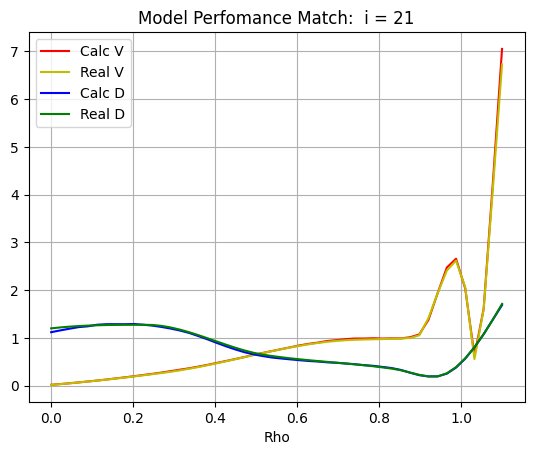

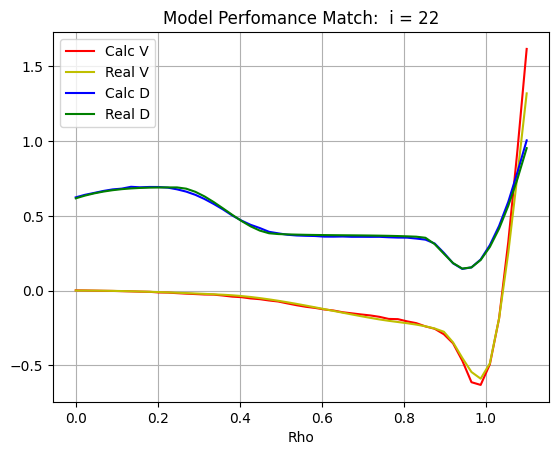

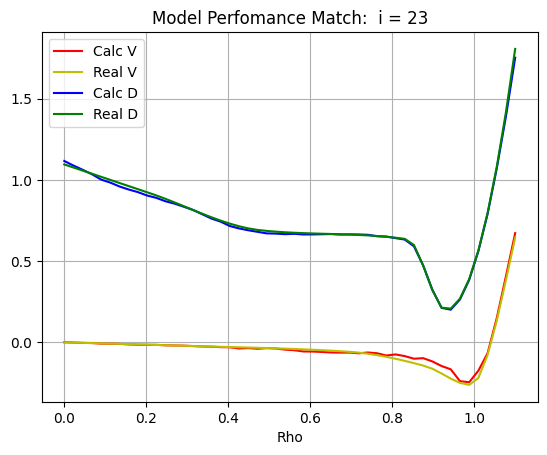

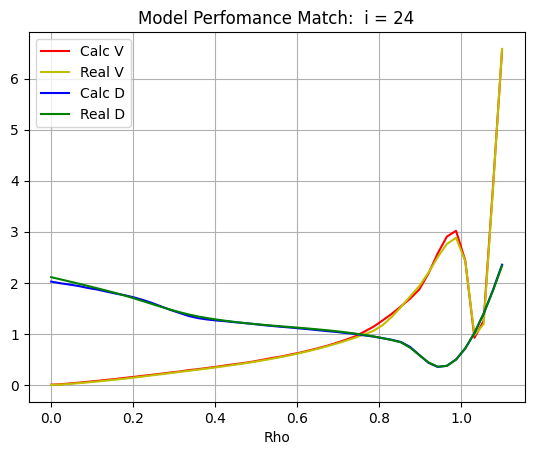

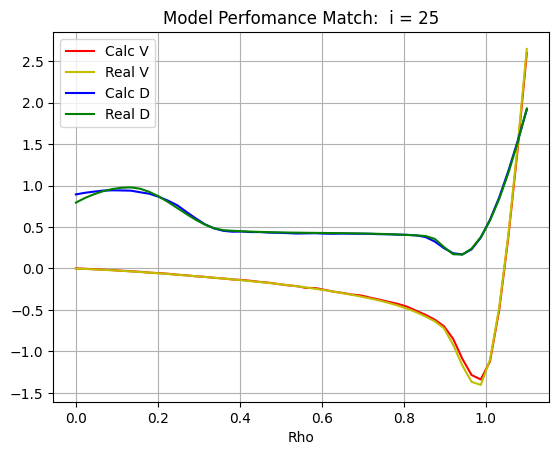

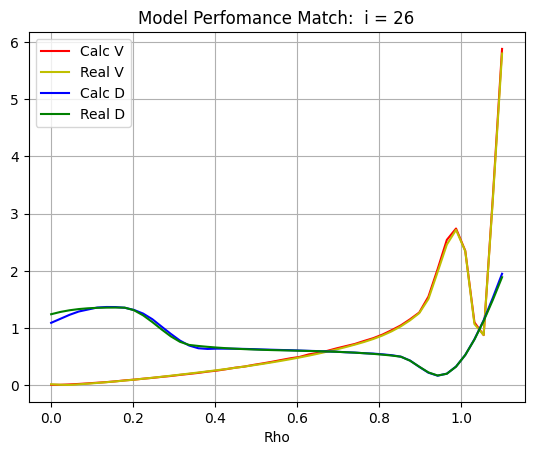

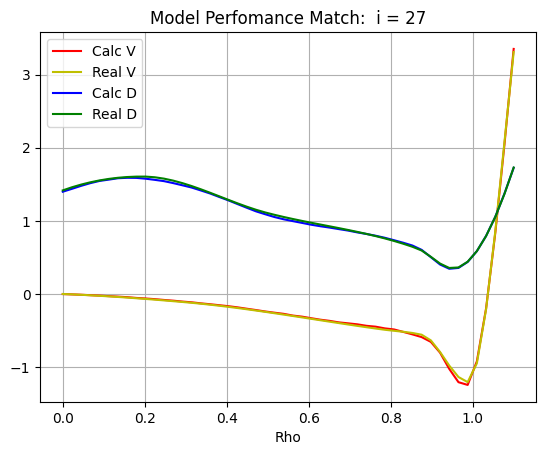

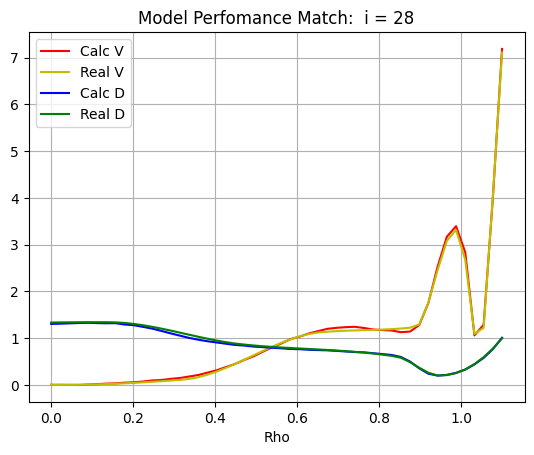

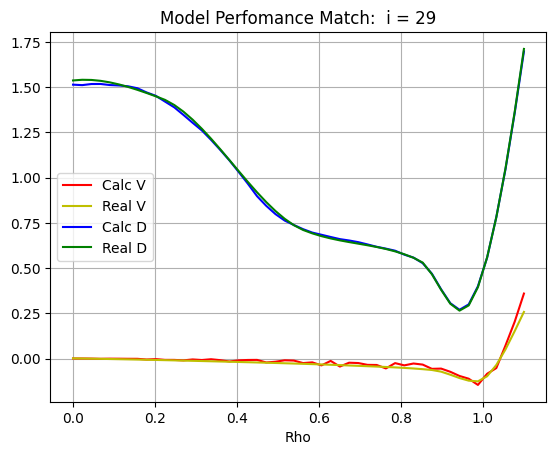

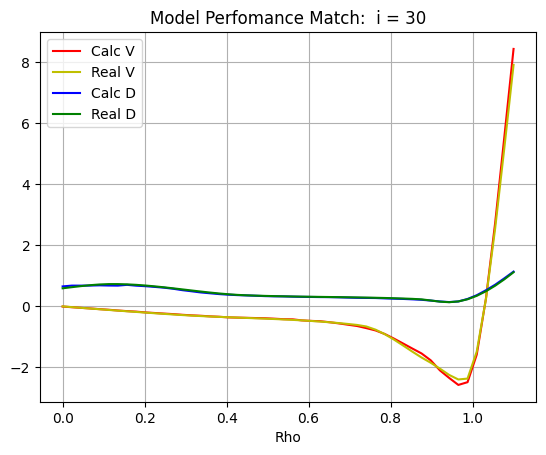

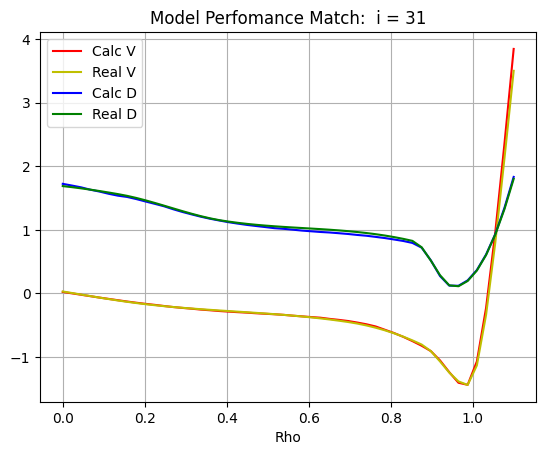

IndexError: index 32 is out of bounds for axis 0 with size 32

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(batch_size):
    PlotRes(i)

## Model Info -- Fix

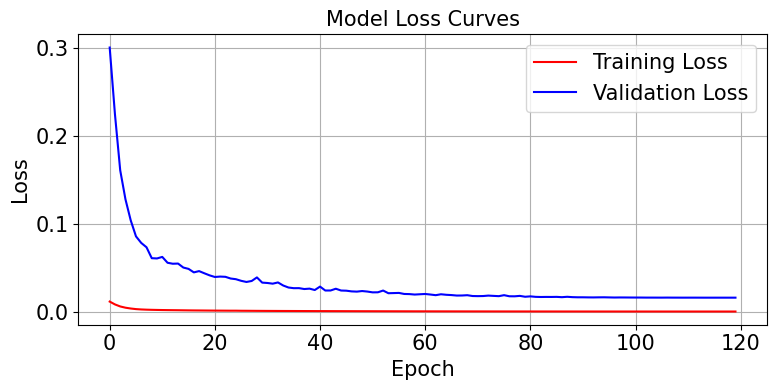

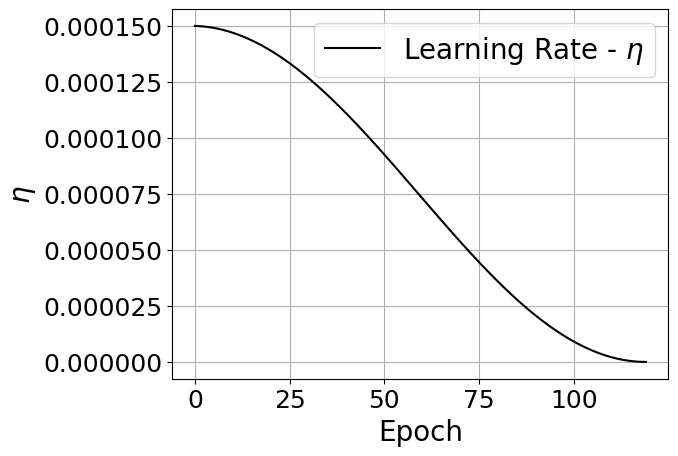

In [ ]:
train_loss = history['train_loss']
val_loss = history['val_loss']
learning_rate = history['lr']

fig1 = plt.figure(figsize=(8,4))
plt.plot(train_loss,'r-',label="Training Loss")
plt.plot(val_loss,'b-',label='Validation Loss')
plt.legend(fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Model Loss Curves', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('Loss.svg', format='svg')
plt.show()

fig2 = plt.figure()
plt.plot(learning_rate,'k-',label=r"Learning Rate - $\eta$")
plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel(r'$\eta$',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.grid()
plt.show()

In [ ]:
# model.eval()
# torch.save(model.state_dict(), 'NNv4_weights120ep.pth')

In [ ]:
nt = 1000
nr = 50

In [ ]:
model = CustomCNN()
model.load_state_dict(torch.load('NNv4_weights120ep.pth'))

C:\Users\Jim\AppData\Local\Temp\ipykernel_38784\3690309312.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('NNv4_weights120ep.pth'))


<All keys matched successfully>

In [ ]:
#Startup
print('Initializing Network')
t_init = timer.time()

#Define Rho and Time Arrays
t = np.linspace(tmin, tmax, nt)
r = np.linspace(rmin, rmax, nr)

#Initialize Scalers
scalerN = StandardScaler()
scalerS = StandardScaler()
scalerD = StandardScaler()
scalerV = StandardScaler()

#Import Raw Data and Scale
input2d_array = np.array([i["N"] for i in data]).astype(np.float32) #N
input1d_array = scalerS.fit_transform(np.array([i["S"] for i in data]).astype(np.float32)) #S
input_t_array = np.array([t for _ in range(samples)]).astype(np.float32) #t
input_r_array = np.array([r for _ in range(samples)]).astype(np.float32) #r
target1 = scalerD.fit_transform(np.array([i["D"] for i in data]).astype(np.float32)) #D
target2 = scalerV.fit_transform(np.array([i["V"] for i in data]).astype(np.float32)) #V

#Process N Data
input2d_array_reshaped = input2d_array.reshape(-1, input2d_array.shape[1])
input2d_array_reshaped_scaled = scalerN.fit_transform(input2d_array_reshaped)
input2d_array = input2d_array_reshaped_scaled.reshape(input2d_array.shape)

(train_data, val_data, test_data) = split_data(input2d_array, input1d_array, input_t_array, input_r_array, target1, target2)

#Initialize DataSets
train_dataset = CustomDataset(*train_data)
val_dataset = CustomDataset(*val_data)
test_dataset = CustomDataset(*test_data)

#Initialize Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = model.to(device)

t_start = timer.time()
print(f'Initialization Took {round(t_start - t_init,2)}s')

Initializing Network
Initialization Took 159.23s


In [ ]:
O1 = 1; O2 = 2; T1 = 1; T2 = 2
model.eval()
with torch.no_grad():
    for input2d, input1d, input_t, input_r, target1, target2 in test_loader:
            input2d, input1d = input2d.to(device), input1d.to(device)
            input_t = input_t.to(device)
            input_r = input_r.to(device)
            target1, target2 = target1.to(device), target2.to(device)

            output1, output2 = model(input2d, input1d, input_t, input_r)
            O1 = output1.cpu().numpy()
            O2 = output2.cpu().numpy()
            T1 = target1.cpu().numpy()
            T2 = target2.cpu().numpy()

Output1_check = scalerD.inverse_transform(O1)
Output2_check = scalerV.inverse_transform(O2)
Target1_check = scalerD.inverse_transform(T1)
Target2_check = scalerV.inverse_transform(T2)

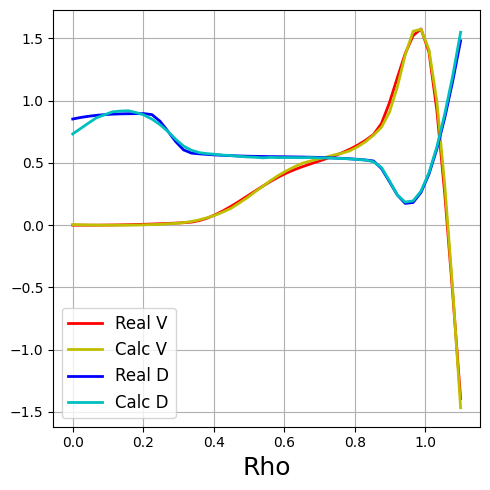

In [ ]:
index = 31
Fig = plt.figure(figsize=(5,5))
Output1_check_idx = Output1_check[index]
Output2_check_idx = Output2_check[index]
Target1_check_idx = Target1_check[index]
Target2_check_idx = Target2_check[index]

lw=2

plt.plot(r,Target2_check_idx,'-r', lw=lw, label='Real V')
plt.plot(r,Output2_check_idx,'-y', lw=lw, label='Calc V')
plt.plot(r,Target1_check_idx,'-b', lw=lw, label='Real D')
plt.plot(r,Output1_check_idx,'-c', lw=lw, label='Calc D')

plt.xlabel('Rho',fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
#plt.savefig(f'Example{index}.svg', format='svg')
plt.show()

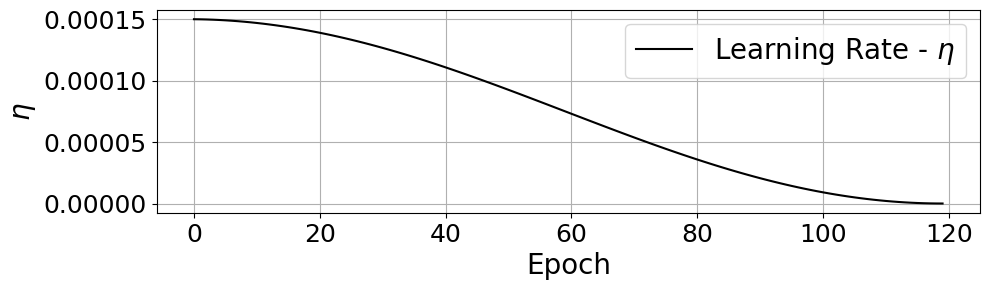

In [ ]:
fig2 = plt.figure(figsize=(10,3))
plt.plot(learning_rate,'k-',label=r"Learning Rate - $\eta$")
plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.ylabel(r'$\eta$',fontsize=20)
plt.tick_params(axis='both', labelsize=18)
plt.grid()
plt.tight_layout()
#plt.savefig(f'Scheduler.svg', format='svg')
plt.show()

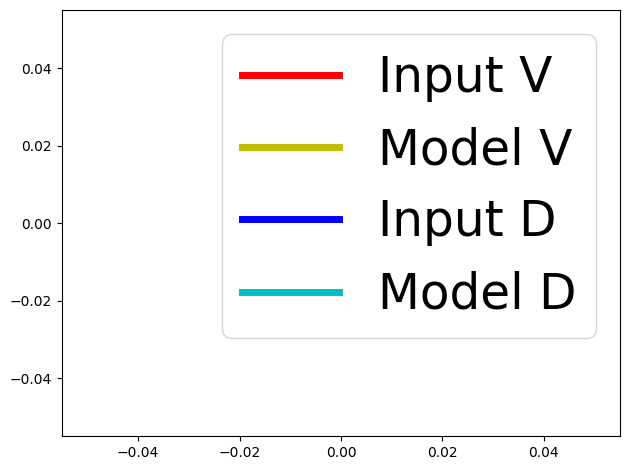

In [ ]:
plt.plot([],[],'-r',lw=5,label='Input V')
plt.plot([],[],'-y',lw=5,label='Model V')
plt.plot([],[],'-b',lw=5,label='Input D')
plt.plot([],[],'-c',lw=5,label='Model D')
plt.legend(fontsize=35)
plt.tight_layout()
#plt.savefig(f'Legend.svg', format='svg')
plt.show()